# Bike sharing demand prediction (Kaggle competition)

### Data preprocessing and EDA

Dataset : <a href = https://www.kaggle.com/c/bike-sharing-demand> Kaggle Bike sharing demand competition<a>
#### Steps : 
    1) Data preprocessing 
    2) EDA
    3) Model testing
    4) Hyperparameter tuning

## 1) Data preprocessing

In [6]:
# Import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.feature_selection import f_regression, mutual_info_regression

In [7]:
# Read data files

train = pd.read_csv("train.csv", parse_dates = ["datetime"])
test = pd.read_csv("test.csv", parse_dates = ["datetime"])
print("""Train shape : {}
Test shape : {}""".format(train.shape, test.shape))

Train shape : (10886, 12)
Test shape : (6493, 9)


#### Let's look at the train data and check if it has any missing values.

In [8]:
train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [9]:
print("""Missing values in train data = {}
Missing values in test data = {}""".format(train.isna().sum().sum(), test.isna().sum().sum()))

Missing values in train data = 0
Missing values in test data = 0


In [10]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


.

season, holiday, workingday and weather are categorical features. We will onehot encode season and encode weather column ordinally as weather category labels are given according to the severity of the weather. Before that, we will add some temporal features to the data. As we are given the hourly data of first 19 days of each month, we cannot use day of month as a feature. But we can use day of week and hour of day.

In [11]:
train_x = train.drop(["casual", "registered", "count"], axis = 1)
train_y = train[["casual", "registered", "count"]]
test_dt = test["datetime"]

.

Count is the sum of casual and registered bike rides. As these two columns capture different trends, we will predict casual and registered rides seperately and then add them to get total hourly count.

In [12]:
def add_temporal_feats(df):
    df_copy = df.copy()
    df_copy["dayofweek"] = df["datetime"].dt.dayofweek
    df_copy["hourofday"] = df["datetime"].dt.hour
    return df_copy

In [13]:
train_x_feats_added = add_temporal_feats(train_x)
test_feats_added = add_temporal_feats(test)

.

Now encoding season and weather columns

In [14]:
def encode_feats(train_x, test_x):
    ct = make_column_transformer((OneHotEncoder(), ["season"]),
                            (OrdinalEncoder(), ["weather"]),
                             ("drop", ["datetime"]), remainder="passthrough",)
    columns = ["season_1", "season_2", "season_3", "season_4", "weather"] + train_x.drop(["season", "weather", "datetime"],
                                                                                        axis = 1).columns.tolist()
    
    train_enc = ct.fit_transform(train_x)
    test_enc = ct.transform(test_x)
    
    train_df = pd.DataFrame(train_enc, columns = columns)
    test_df = pd.DataFrame(test_enc, columns = columns)
    
    return train_df, test_df

In [15]:
train_enc_df, test_enc_df = encode_feats(train_x_feats_added, test_feats_added)

.

Merge feature and target variables for EDA

In [16]:
train_merged = pd.concat([train_enc_df, train_y], axis = 1, join = "inner")

## 2) EDA

First we look at how the features are correlated to the target variables.
For numerical variables, the correlation coeeficient is useful and for categorical variables, f statistic values.

In [17]:
numeric_feats = ["temp", "atemp", "humidity", "windspeed"]

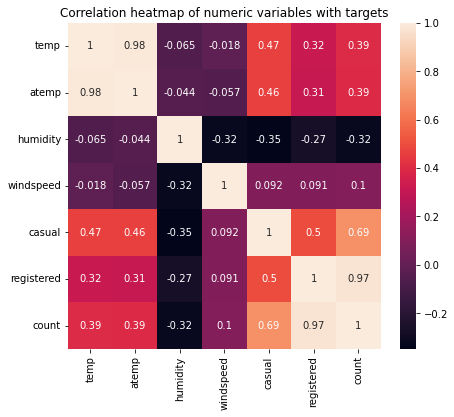

In [18]:
plt.figure(figsize = (7,6))
sns.heatmap(train_merged[numeric_feats+["casual", "registered", "count"]].corr(),annot = True)
plt.title("Correlation heatmap of numeric variables with targets")
plt.show()

Strong correlation between numeric features and targets. 

In [24]:
f_casual = f_regression(train_enc_df.drop(numeric_feats, axis = 1), y = train_y["casual"])
f_casual /= np.max(f_casual)
f_registered = f_regression(train_enc_df.drop(numeric_feats, axis = 1), y = train_y["registered"])
f_registered /= np.max(f_registered)

feature_f = pd.DataFrame({"feature":train_enc_df.drop(numeric_feats, axis = 1).columns,
             "casual_f":f_casual[0], "registered_f":f_registered[0]})
feature_f

,feature,casual_f,registered_f
0,season_1,0.516596,0.265118
1,season_2,0.157385,0.013057
2,season_3,0.322184,0.062262
3,season_4,0.066117,0.019223
4,weather,0.166006,0.071457
5,holiday,0.016953,0.002595
6,workingday,1.000000,0.085497
7,dayofweek,0.572864,0.042397
8,hourofday,0.885453,1.000000


Many categorical features are correlated with the casual count, but not with registered count.

In [19]:
test_cols = test_enc_df.columns.tolist()
test_merged = test_enc_df.merge(test_dt, left_index = True, right_index=True)
test_merged = test_merged[["datetime"]+test_cols]

Save train and test datasets for model training

In [24]:
train_merged.to_csv("train_preprocessed.csv", index = False)
test_merged.to_csv("test_preprocessed.csv", index = False)